### Unstructured pipeline for processing documents for RAG

Partition PDF documents into a list of `Element` objects, preserving the semantic structure of documents.

Unstructured uses a layout detection model (`yolox` by default) to find text elements and tables (whether they are bordered or borderless), extracts the contents, using OCR if necessary. 


[Unstructured](https://github.com/Unstructured-IO)

[yolox documentation](https://yolox.readthedocs.io/en/latest/)

In [15]:
%load_ext autoreload
%autoreload 2
# %pip install -qU pypdf
# %pip install --upgrade --quiet langchain-unstructured unstructured-client unstructured "unstructured[pdf]" python-magic

In [1]:
import os
import sys
import json
if "../src" not in sys.path:
    sys.path.append("../src")
import utils
import settings
from IPython.display import HTML, display
from pdf_processor import PdfProcessor
from pathlib import Path

wrapper = utils.get_text_wrapper()

Get some test PDFs

In [2]:
pdfs = [
    {
        "file_path": settings.DATA_DIR / "acs" / "Admitere_licenta_ACS_2025_Sesiunea1_SintezaACS.pdf",
        "url": "https://acs.pub.ro/public/Admitere_licenta_ACS_2025_Sesiunea1_SintezaACS.pdf",
        "output_dir": settings.DATA_DIR / "content" / "acs",
    },
    {
        "file_path": Path("/home/ana/ACS/rag/test_data") / "admitere" / "Test limba straina 21 03 detalii S1 2025.pdf",
        "url": "https://admitere.pub.ro/docs/Test%20limba%20straina%2021%2003%20detalii%20S1%202025.pdf",
        "output_dir": Path("/home/ana/ACS/rag/test_data") / "content" / "admitere",
    }
]

for pdf in pdfs:
    os.makedirs(pdf["output_dir"], exist_ok=True)

In [3]:
# pdf = pdfs[0]
pdf = pdfs[1]
file_path, url = pdf["file_path"], pdf["url"]

In [4]:
pdfProcessor = PdfProcessor(file_path, url=url)

# Experimented with converting the pdf to black and white first
# Maybe go back to looking into this later
# pdfProcessor.convert_to_bw()
# pdfProcessor.apply_ocr(bw=True)

#### Partition PDF
Use langchain unstructured to extract structured content from pdf: text, tables and images

In [5]:
pdfProcessor.partition_pdf()

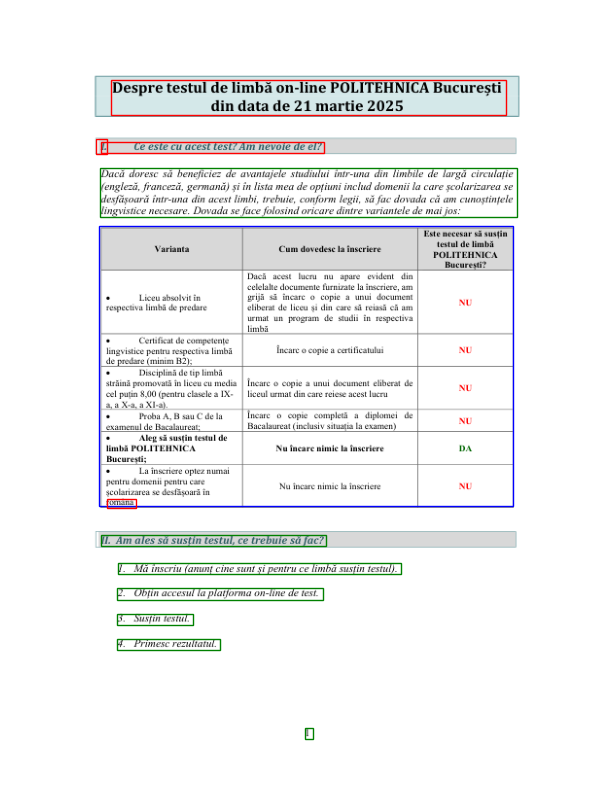

In [6]:
pdfProcessor.render_page(1)
# pdfProcessor.render_page(2)

In [7]:
for element in pdfProcessor.elements:
    print(wrapper.fill(f"Category: {element.category}"))
    print(wrapper.fill(f"Page number: {element.metadata.page_number}"))
    print(wrapper.fill(f"Text: {element.text}"))
    print('-' * wrapper.width)

Category: Title
Page number: 1
Text: Despre testul de limbă on-line POLITEHNICA București din data de 21 martie 2025
------------------------------------------------------------------------------------------------------------------------
Category: Title
Page number: 1
Text: L
------------------------------------------------------------------------------------------------------------------------
Category: Title
Page number: 1
Text: Ce este cu acest test? Am nevoie de el?
------------------------------------------------------------------------------------------------------------------------
Category: NarrativeText
Page number: 1
Text: Dacă doresc să beneficiez de avantajele studiului într-una din limbile de largă circulație (engleză, franceză,
germană) și în lista mea de opțiuni includ domenii la care școlarizarea se desfășoară într-una din acest limbi, trebuie,
conform legii, să fac dovada că am cunoștințele lingvistice necesare. Dovada se face folosind oricare dintre variantele
de mai 

Display HTML table

In [8]:
table = pdfProcessor._get_tables()[0]
display(HTML(table.metadata.text_as_html))

Varianta,Cum dovedesc la înscriere,Este necesar să susțin testul de limbă POLITEHNICA Bucureşti?
L Liceu absolvit în respectiva limbă de predare,"Dacă acest lucru nu apare evident din celelalte documente furnizate la înscriere, am grijă să încarc o copie a unui document eliberat de liceu şi din care să reiasă că am urmat un program de studii în respectiva limbă",NU
L Certificat de competențe lingvistice pentru respectiva limbă de predare (minim B2);,Încarc o copie a certificatului,NU
"L Disciplină de tip limbă străină promovată în liceu cu media | cel puțin 8,00 (pentru clasele a IX- | a,a X-a, a XI-a).",Încarc o copie a unui document eliberat de liceul urmat din care reiese acest lucru,NU
"L Proba A, B sau C de la examenul de Bacalaureat;",Încare o copie completă a diplomei de Bacalaureat (inclusiv situaţia la examen),NU
L Aleg să susțin testul de limbă POLITEHNICA Bucureşti;,Nu încarc nimic la înscriere,DA
L La înscriere optez numai pentru domenii pentru care şcolarizarea se desfăşoară în româna,Nu încarc nimic la înscriere,NU


Display the HTML code

In [9]:
# from bs4 import BeautifulSoup
# soup = BeautifulSoup(table.metadata.text_as_html, "html.parser")
# print(wrapper.fill(soup.prettify()))

#### Clean up table
TODO: improve - currently kinda hardcoded, based on some common sense observations from this particular example.

In [16]:
pdfProcessor.cleanup()
display(HTML(table.metadata.text_as_html))

Varianta,Cum dovedesc la înscriere,Este necesar să susțin testul de limbă POLITEHNICA Bucureşti?
Liceu absolvit în respectiva limbă de predare,"Dacă acest lucru nu apare evident din celelalte documente furnizate la înscriere, am grijă să încarc o copie a unui document eliberat de liceu şi din care să reiasă că am urmat un program de studii în respectiva limbă",NU
Certificat de competențe lingvistice pentru respectiva limbă de predare (minim B2);,Încarc o copie a certificatului,NU
"Disciplină de tip limbă străină promovată în liceu cu media cel puțin 8,00 (pentru clasele a IX- a,a X-a, a XI-a).",Încarc o copie a unui document eliberat de liceul urmat din care reiese acest lucru,NU
"Proba A, B sau C de la examenul de Bacalaureat;",Încare o copie completă a diplomei de Bacalaureat (inclusiv situaţia la examen),NU
Aleg să susțin testul de limbă POLITEHNICA Bucureşti;,Nu încarc nimic la înscriere,DA
L La înscriere optez numai pentru domenii pentru care şcolarizarea se desfăşoară în româna,Nu încarc nimic la înscriere,NU


Display table as cells

In [11]:
# print(json.dumps(table.metadata.table_as_cells, indent=4, ensure_ascii=False))

#### Split document into chunks for OpenSearch ingestion

In [12]:
pdfProcessor.perform_chunking()

In [13]:
for chunk in pdfProcessor.chunks:
    print(wrapper.fill(json.dumps(chunk, indent=4, ensure_ascii=False)))

{
    "id": "9cf23be3e6b1bcbd56f0cab3918a505c41688bb641a64cac3a8509bc9628e5d1-1",
    "text": "Despre testul de limbă
on-line POLITEHNICA București din data de 21 martie 2025 L Ce este cu acest test? Am nevoie de el? Dacă doresc să
beneficiez de avantajele studiului într-una din limbile de largă circulație (engleză, franceză, germană) și în lista mea
de opțiuni includ domenii la care școlarizarea se desfășoară într-una din acest limbi, trebuie, conform legii, să fac
dovada că am cunoștințele lingvistice necesare. Dovada se face folosind oricare dintre variantele de mai jos:",
"url": "https://admitere.pub.ro/docs/Test%20limba%20straina%2021%2003%20detalii%20S1%202025.pdf",
    "type": "pdf",
"filename": "Test limba straina 21 03 detalii S1 2025.pdf",
    "page_number": 1,
    "table_id": null,
"table_text": null
}
{
    "id": "9cf23be3e6b1bcbd56f0cab3918a505c41688bb641a64cac3a8509bc9628e5d1-2",
    "text": "Varianta ; Cum dovedesc
la înscriere ; Este necesar să susțin testul de limbă PO

In [14]:
with open("output.json", "w+") as file:
    file.write(json.dumps(pdfProcessor.chunks, indent=4, ensure_ascii=False))